## Ensemble Agents

In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 12

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

### Download Data

In [4]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-11-10'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-10'
TEST_END_DATE = '2023-11-11'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [9]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-11-10,11.308571,11.384643,11.198214,9.628128,384227200,AAPL,2
1,2010-11-10,54.759998,54.939999,53.970001,39.629807,6174200,AMGN,2
2,2010-11-10,43.529999,43.660000,43.040001,36.089191,9757300,AXP,2
3,2010-11-10,67.690002,67.690002,66.790001,53.569656,10494700,BA,2
4,2010-11-10,82.160004,82.839996,81.300003,58.525681,5944000,CAT,2


In [10]:
df.tail()

,date,open,high,low,close,volume,tic,day
96084,2023-11-10,542.679993,542.679993,536.020020,539.369995,2480800,UNH,4
96085,2023-11-10,243.979996,245.270004,241.970001,245.250000,4094400,V,4
96086,2023-11-10,35.910000,35.919998,35.400002,35.709999,12791200,VZ,4
96087,2023-11-10,20.580000,20.809999,20.350000,20.280001,8793700,WBA,4
96088,2023-11-10,164.550003,166.440002,163.899994,166.190002,4773300,WMT,4


In [11]:
df.shape

(96089, 8)

In [12]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-11-10,11.308571,11.384643,11.198214,9.628128,384227200,AAPL,2
1,2010-11-10,54.759998,54.939999,53.970001,39.629807,6174200,AMGN,2
2,2010-11-10,43.529999,43.660000,43.040001,36.089191,9757300,AXP,2
3,2010-11-10,67.690002,67.690002,66.790001,53.569656,10494700,BA,2
4,2010-11-10,82.160004,82.839996,81.300003,58.525681,5944000,CAT,2


In [13]:
len(df.tic.unique())

30

In [14]:
df.tic.value_counts()

tic
AAPL    3273
AMGN    3273
WMT     3273
WBA     3273
VZ      3273
V       3273
UNH     3273
TRV     3273
PG      3273
NKE     3273
MSFT    3273
MRK     3273
MMM     3273
MCD     3273
KO      3273
JPM     3273
JNJ     3273
INTC    3273
IBM     3273
HON     3273
HD      3273
GS      3273
DIS     3273
CVX     3273
CSCO    3273
CRM     3273
CAT     3273
BA      3273
AXP     3273
DOW     1172
Name: count, dtype: int64

### Preprocess Data

In [ ]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [15]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
68413,2020-03-27,87.940002,91.970001,85.820000,84.116699,6999800,AXP,4,-8.859413,114.812220,61.465001,41.950671,-58.396868,9.050244,98.898018,111.199519,115.916483
2289,2011-03-04,42.470001,42.970001,42.009998,28.462395,5729300,WBA,4,0.231837,29.128887,27.842095,57.475271,52.783121,5.493097,28.254891,27.256551,0.000000
86963,2022-10-10,87.760002,87.779999,85.070000,85.321869,7991200,NKE,0,-5.313258,109.904455,79.654957,37.465614,-126.642642,37.113094,98.582304,104.333087,36.918134
48278,2017-06-22,89.269997,89.410004,88.900002,74.625992,4536700,PG,3,0.447826,75.589601,72.802371,54.853642,85.472391,16.237569,73.551121,73.825607,19.637121
41183,2016-07-05,128.429993,129.000000,126.629997,115.862099,4829400,BA,1,-0.632787,123.863157,112.949243,47.555320,-50.439456,13.241873,117.906750,118.828147,15.747079



### Design Environment

In [18]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [19]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}


### Agents


In [20]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [21]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [22]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  205.37592673155712
======Model training from:  2010-11-10 to  2022-11-11
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0.0731    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -39.4     |
|    reward             | 1.0534707 |
|    std                | 0.999     |
|    value_loss         | 1.51      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 81

In [23]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-11-11,2023-02-14,A2C,0.141506,-0.078985,0.048616
1,189,2023-02-14,2023-05-16,PPO,-0.019843,0.106682,0.105881


### Backtest


In [24]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [26]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.3088070114418804


In [27]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2023-02-14,NaN,2023-02-14
1,999928.938597,2023-02-15,-0.000071,2023-02-15
2,996650.013815,2023-02-16,-0.003279,2023-02-16
3,999956.189560,2023-02-17,0.003317,2023-02-17
4,990512.584827,2023-02-21,-0.009444,2023-02-21


<Axes: >

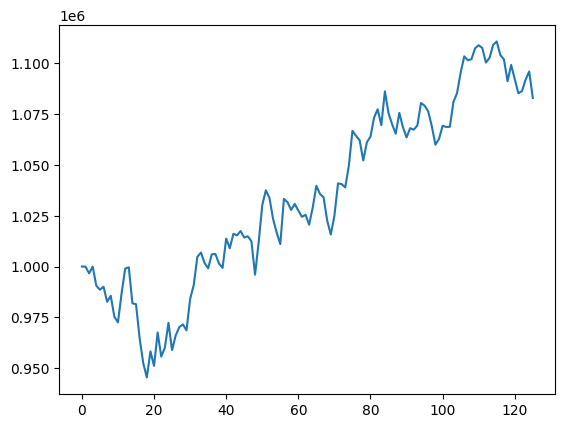

In [28]:
%matplotlib inline
df_account_value.account_value.plot()

### BackTestStats


In [29]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.172871
Cumulative returns     0.082992
Annual volatility      0.129155
Sharpe ratio           1.308807
Calmar ratio           3.163124
Stability              0.885189
Max drawdown          -0.054652
Omega ratio            1.232837
Sortino ratio          2.108003
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.324459
Daily value at risk   -0.015601
dtype: float64


In [30]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (125, 8)
Annual return          0.073361
Cumulative returns     0.035740
Annual volatility      0.118775
Sharpe ratio           0.659841
Calmar ratio           1.084348
Stability              0.638280
Max drawdown          -0.067654
Omega ratio            1.113145
Sortino ratio          0.960162
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.111121
Daily value at risk   -0.014653
dtype: float64


In [31]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2023-02-14  1.000000e+06
1    2023-02-15  1.001138e+06
2    2023-02-16  9.884885e+05
3    2023-02-17  9.922973e+05
4    2023-02-21  9.718480e+05
..          ...           ...
121  2023-08-09  1.030335e+06
122  2023-08-10  1.031883e+06
123  2023-08-11  1.034971e+06
124  2023-08-14  1.035740e+06
125  2023-08-15           NaN

[126 rows x 2 columns]
df_dji:                       dji
date                    
2023-02-14  1.000000e+06
2023-02-15  1.001138e+06
2023-02-16  9.884885e+05
2023-02-17  9.922973e+05
2023-02-21  9.718480e+05
...                  ...
2023-08-09  1.030335e+06
2023-08-10  1.031883e+06
2023-08-11  1.034971e+06
2023-08-14  1.035740e+06
2023-08-15           NaN

[126 rows x 1 columns]



### BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2022-11-11
1    2022-11-14
2    2022-11-15
3    2022-11-16
4    2022-11-17
..          ...
246  2023-11-06
247  2023-11-07
248  2023-11-08
249  2023-11-09
250  2023-11-10

[251 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2023-02-14  1.000000e+06
2023-02-15  9.999289e+05
2023-02-16  9.966500e+05
2023-02-17  9.999562e+05
2023-02-21  9.905126e+05
...                  ...
2023-08-09  1.085294e+06
2023-08-10  1.086390e+06
2023-08-11  1.092005e+06
2023-08-14  1.096039e+06
2023-08-15  1.082992e+06

[126 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2023-02-14  1.000000e+06  1.000000e+06
2023-02-15  9.999289e+05  1.001138e+06
2023-02-16  9.966500e+05  9.884885e+05
2023-02-17  9.999562e+05  9.922973e+05
2023-02-21  9.905126e+05  9.718480e+05
...       

<Figure size 1500x500 with 0 Axes>

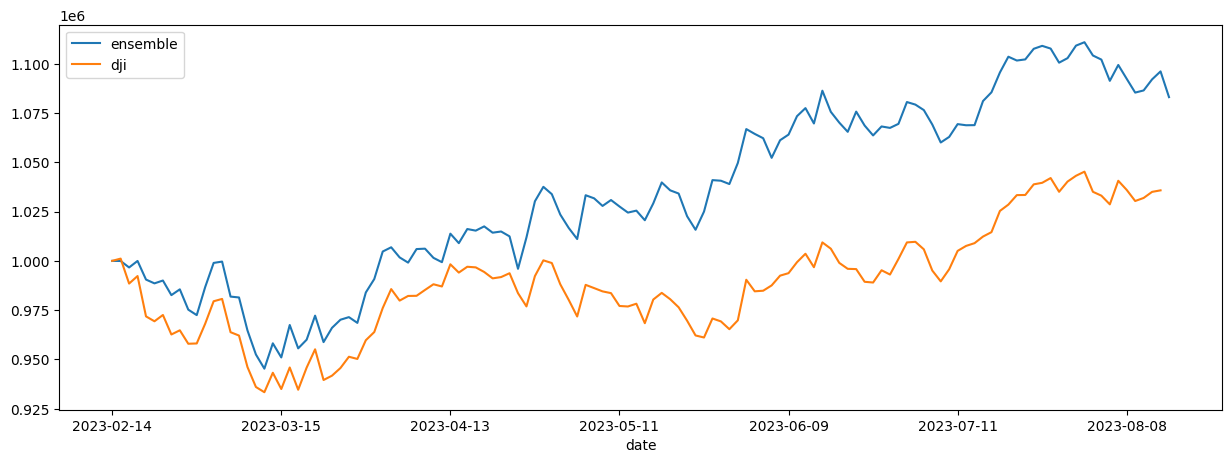

In [32]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
